#### Dimensionalize simulations with variable material properties
I have nondimensional time for RBC sedimentation. I need to convert that to dimensional time, but the result depends on the physical characteristics of the blood. Write functions to get dimensional time from variable material properties and probe parameter sensitivity.  

Support experiment setup by calculating dilution hematocrits

In [1]:
from scipy.optimize import minimize,fsolve
import numpy as np
import velocity_functions as vf
import matplotlib.pyplot as plt

#### Convert from non-dimensional time to dimensioned time

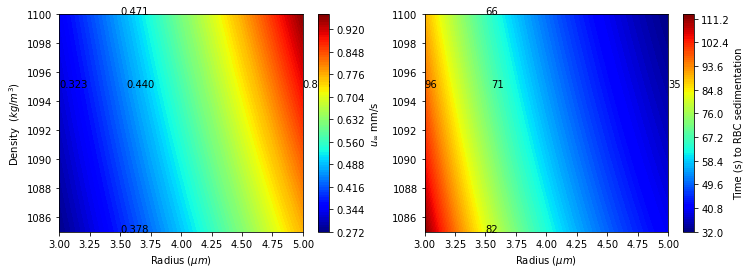

Final time for ρ 1085,1100   is 82,66 s
Final time for r 3e-06,5e-06 is 96,35 s


In [38]:
def dimtime(nondim_time,L,u1_inf):
    return  nondim_time*L/u1_inf

nL = 51
nt = 51
nd = 101
nr = 101

myndt = 1.56
myr   = 3.5e-6
myρ   = 1095


ρlo,ρhi = 1085,1100
rlo,rhi = 3e-6,5e-6

L0 = 0.04
Lw = 0.06
Ls = np.linspace(L0,Lw,nL) # m
density = np.linspace(ρlo,ρhi,nd)
radius  = np.linspace(rlo,rhi,nr)
nondim_time = np.linspace(1,2,nt)

uρlo,uρhi = vf.stokes(3000,Lw,myr,ρlo),vf.stokes(3000,Lw,myr,ρhi)
urlo,urhi = vf.stokes(3000,Lw,rlo,myρ),  vf.stokes(3000,Lw,rhi,myρ)

myu0  = vf.stokes(3000,Lw,myr,myρ)
mytf  = dimtime(myndt,Lw-L0,myu0)

tρlo,tρhi = dimtime(myndt,Lw-L0,uρlo),dimtime(myndt,Lw-L0,uρhi)
trlo,trhi = dimtime(myndt,Lw-L0,urlo),dimtime(myndt,Lw-L0,urhi)

# Variability in stokes velocity and dimensional time with cell parameters
u0 = np.empty((nr,nd))
tf = np.empty((nr,nd))
for r in range(nr):
    for d in range(nd):
        u0[r,d] = vf.stokes(3000,Lw,radius[r],density[d])
        tf[r,d] = dimtime(myndt,Lw-L0,u0[r,d])



# u0 /= np.max(u0)
# tf /= 52 #np.max(tf)

fig,ax = plt.subplots(ncols=2,figsize=(12,4),sharex=True) #,gridspec_kw={'width_ratios': [1, 1]})
levels = 101
D,R    = np.meshgrid(density,radius*1e6)
u0plot = ax[0].contourf(R,D,u0*1e3,levels,cmap=plt.cm.jet)
tfplot = ax[1].contourf(R,D,tf,    levels,cmap=plt.cm.jet)


fig.colorbar(u0plot,ax=ax[0],label=f'$u_\infty$ mm/s')
fig.colorbar(tfplot,ax=ax[1],label=f'Time (s) to RBC sedimentation')

ax[0].text(myr*1e6+.05,myρ,f'{myu0*1e3:.3f}')
ax[1].text(myr*1e6+.05,myρ,f'{mytf:.0f}')
[ax[0].text(r*1e6,ρ,f'{u*1e3:.3f}') for r,ρ,u in zip((rlo,rhi,myr,myr),(myρ,myρ,ρlo,ρhi),(urlo,urhi,uρlo,uρhi))]
[ax[1].text(r*1e6,ρ,f'{t:.0f}') for r,ρ,t in zip((rlo,rhi,myr,myr),(myρ,myρ,ρlo,ρhi),(trlo,trhi,tρlo,tρhi))]

[axx.set_xlabel(f'Radius ($\mu m$)') for axx in ax]
ax[0].set_ylabel(f'Density  ($kg/m^3$)')
plt.show()
print(f'Final time for ρ {ρlo},{ρhi}   is {tρlo:.0f},{tρhi:.0f} s')
print(f'Final time for r {rlo},{rhi} is {trlo:.0f},{trhi:.0f} s')

blood cells move through capillaries at 0.3mm/s, which is a little slower than the stokes velocity at 600xg

Marieb, Elaine N.; Hoehn, Katja (2013). "The Cardiovascular System:Blood Vessels". Human anatomy & physiology (9th ed.). Pearson Education. p. 712

#### Find blood dilution values for experiments
Specifically I need:   
1. Total hematocrit for treatment groups  
2. Extra volume to add for dilution  
  * Calculation in math lab book

ρ,f for maximum flux: 0.148       0.059
ρ,f for equal fluxes: 0.050 0.308 0.037


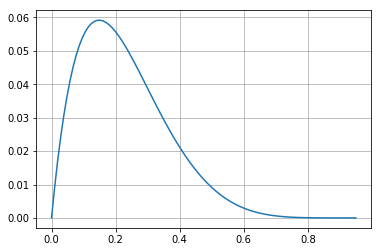

In [3]:
def michaels_flux(ρ,**kwargs):
    return vf.michaels(ρ,2.71,amax=0.95)*ρ*(1-ρ)

amax=0.95
n=101
ρs = np.linspace(0,amax,n)
plt.plot(ρs,michaels_flux(ρs))
plt.grid()

ρfm = minimize(lambda ρ: -michaels_flux(ρ,n=2.71,amax=0.95),0.2) # density for max flux
ρ_lo = 0.05
ρ_hi = fsolve(lambda ρ_hi: michaels_flux(ρ_hi)-michaels_flux(ρ_lo),0.4)

print(f'ρ,f for maximum flux: {ρfm.x[0]:0.3f}       {-ρfm.fun:0.3f}')
print(f'ρ,f for equal fluxes: {ρ_lo:.3f} {ρ_hi[0]:.3f} {michaels_flux(ρ_hi[0],n=2.71,amax=0.95):.3f}')